In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dir = 'round_3_2025/'

def simple_mid_price(row):
    bid = row[3]
    ask = row[9]
    if np.isnan(bid):
        bid = 0
    elif np.isnan(ask):
        ask = 0
    return (bid+ask) / 2

prices_1_0 = pd.read_csv(dir+"prices_round_3_day_0.csv", delimiter=';')
prices_1_1 = pd.read_csv(dir+"prices_round_3_day_1.csv", delimiter=';')
prices_1_1['timestamp'] += 1000000 # shift day 2 to 0-24h
prices_1_2 = pd.read_csv(dir+"prices_round_3_day_2.csv", delimiter=';')
prices_1_2['timestamp'] += 2000000 # shift day 2 to 0-24h

prices = pd.concat([prices_1_0, prices_1_1, prices_1_2])
prices['mid_price'] = prices.apply(simple_mid_price, axis=1)

prices = pd.concat([prices_1_0, prices_1_1, prices_1_2])

In [ ]:
vouchers = ['VOLCANIC_ROCK_VOUCHER_10500', 'VOLCANIC_ROCK_VOUCHER_10000', 
            'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_9500',
            'VOLCANIC_ROCK_VOUCHER_10250']

voucher_df = prices[prices['product'].isin(vouchers)]
voucher_df.reset_index(drop=True, inplace=True)

# each round has 1 mil stamps
start_time = 1000000 * 8 # starting at day 0, expires on day 8

voucher_df['strike_price'] = voucher_df['product'].apply(lambda x: int(x.split('_')[-1]))
voucher_df['strike_price'] = voucher_df['strike_price'].astype(int)
voucher_df['time_to_expiry'] = (start_time - voucher_df['timestamp']) / 365e6 # convert to years

spot_price = prices[prices['product'] == 'VOLCANIC_ROCK'][['mid_price', 'timestamp']]
spot_price.rename(columns={'mid_price': 'underlying_price'}, inplace=True)


voucher_df = pd.merge(voucher_df, spot_price, on='timestamp', how='left')

voucher_df = voucher_df[['timestamp', 'product', 'ask_price_1', 'strike_price', 'time_to_expiry', 'underlying_price', 'bid_price_1']]

# check hwo many nans
print(voucher_df.isna().sum())

# drop nas
voucher_df.dropna(inplace=True)
voucher_df.reset_index(drop=True, inplace=True)
voucher_df.head(10)

# implied vol 

In [ ]:
voucher_df['product'].unique()

In [428]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_call(spot, strike, time_to_expiry, volatility, r=0.0):
    d1 = (np.log(spot / strike) + (r + 0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    call_price = (spot * norm.cdf(d1) - strike * np.exp(-r * time_to_expiry) * norm.cdf(d2))
    return call_price

def black_scholes_put(spot, strike, time_to_expiry, volatility, r=0.0):
    d1 = (np.log(spot / strike) + (r + 0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    put_price = (strike * np.exp(-r * time_to_expiry) * norm.cdf(-d2) - spot * norm.cdf(-d1))
    return put_price

def delta(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.cdf(d1)

def gamma(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.pdf(d1)/(spot * volatility * np.sqrt(time_to_expiry))

def vega(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.pdf(d1) * (spot * np.sqrt(time_to_expiry)) / 100

def theta(spot, strike, time_to_expiry, volatility, r=0.0):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    term1 = -(spot * norm.pdf(d1) * volatility) / (2 * np.sqrt(time_to_expiry))
    term2 = r * strike * np.exp(-r * time_to_expiry) * norm.cdf(d2)
    return term1 - term2

def implied_volatility(row, product, call_price, spot, strike, time_to_expiry, r=0.00):
    # Define the equation where the root is the implied volatility
    def equation(volatility):
        estimated_price = black_scholes_call(spot, strike, time_to_expiry, volatility, r)
        return estimated_price - call_price

    try:
        # Using Brent's method to find the root of the equation
        implied_vol = brentq(equation, 1e-3, 3.0, xtol=1e-10)
    except:
        # print(row, product, 'very far out of the money, returning 0')
        return 0 # has no volatility because so far out of the money
    
    return implied_vol

def realized_vol(df, spot_col='underlying_price', window=1000):
    returns = np.log(df[spot_col] / df[spot_col].shift(1))
    rolling_std = returns.rolling(window=window).std() 
    timesteps_per_year = 365e6
    annualization_factor = np.sqrt(timesteps_per_year / window)
    df['realized_vol'] = rolling_std * annualization_factor
    return df


In [33]:
voucher_df['ask_implied_vol'] = voucher_df.apply(lambda row: implied_volatility(row['timestamp'], row['product'], row['ask_price_1'], row['underlying_price'], row['strike_price'], row['time_to_expiry']), axis=1)
voucher_df['bid_implied_vol'] = voucher_df.apply(lambda row: implied_volatility(row['timestamp'], row['product'], row['bid_price_1'], row['underlying_price'], row['strike_price'], row['time_to_expiry']), axis=1)


# save this so i don't have to recalculate it
voucher_df.to_csv("voucher_df_with_implied_vol_bid_ask.csv", index=False)

In [34]:
voucher_df[voucher_df['bid_implied_vol'] > 1e-3]

,timestamp,product,ask_price_1,strike_price,time_to_expiry,underlying_price,bid_price_1,ask_implied_vol,bid_implied_vol
0,0,VOLCANIC_ROCK_VOUCHER_10500,100,10500,0.021918,10503.0,99.0,0.158801,0.157189
1,0,VOLCANIC_ROCK_VOUCHER_10000,506,10000,0.021918,10503.0,505.0,0.175206,0.164061
2,0,VOLCANIC_ROCK_VOUCHER_9750,755,9750,0.021918,10503.0,754.0,0.234217,0.213510
4,0,VOLCANIC_ROCK_VOUCHER_10250,274,10250,0.021918,10503.0,273.0,0.164492,0.161775
5,100,VOLCANIC_ROCK_VOUCHER_10000,516,10000,0.021918,10510.0,515.0,0.201158,0.194153
...,...,...,...,...,...,...,...,...,...
146731,2999800,VOLCANIC_ROCK_VOUCHER_10000,186,10000,0.013699,10167.5,185.0,0.157085,0.153863
146732,2999900,VOLCANIC_ROCK_VOUCHER_10500,4,10500,0.013699,10166.5,3.0,0.165738,0.156793
146733,2999900,VOLCANIC_ROCK_VOUCHER_10250,37,10250,0.013699,10166.5,36.0,0.149135,0.146789
146734,2999900,VOLCANIC_ROCK_VOUCHER_10000,181,10000,0.013699,10166.5,180.0,0.143269,0.139778


# load df

In [42]:
# load from csv
vouchers_df = pd.read_csv("voucher_df_with_implied_vol_bid_ask.csv")

# # calculate vega
# voucher_df['vega'] = voucher_df.apply(lambda row: vega(row['underlying_price'], row['strike_price'], row['time_to_expiry'], row['implied_vol']), axis=1)
# # calculate delta
# voucher_df['delta'] = voucher_df.apply(lambda row: delta(row['underlying_price'], row['strike_price'], row['time_to_expiry'], row['implied_vol']), axis=1)
# # calculate gamma
# voucher_df['gamma'] = voucher_df.apply(lambda row: gamma(row['underlying_price'], row['strike_price'], row['time_to_expiry'], row['implied_vol']), axis=1)
# voucher_df['realized_vol'] = voucher_df.apply(lambda row: realized_vol(prices[prices['timestamp'] <= row['timestamp']], spot_col='mid_price', window=500)['realized_vol'].iloc[-1], axis=1)

In [45]:
vouchers_df

,timestamp,product,ask_price_1,strike_price,time_to_expiry,underlying_price,bid_price_1,ask_implied_vol,bid_implied_vol
0,0,VOLCANIC_ROCK_VOUCHER_10500,100,10500,0.021918,10503.0,99.0,0.158801,0.157189
1,0,VOLCANIC_ROCK_VOUCHER_10000,506,10000,0.021918,10503.0,505.0,0.175206,0.164061
2,0,VOLCANIC_ROCK_VOUCHER_9750,755,9750,0.021918,10503.0,754.0,0.234217,0.213510
4,0,VOLCANIC_ROCK_VOUCHER_10250,274,10250,0.021918,10503.0,273.0,0.164492,0.161775
5,100,VOLCANIC_ROCK_VOUCHER_10000,516,10000,0.021918,10510.0,515.0,0.201158,0.194153
...,...,...,...,...,...,...,...,...,...
146731,2999800,VOLCANIC_ROCK_VOUCHER_10000,186,10000,0.013699,10167.5,185.0,0.157085,0.153863
146732,2999900,VOLCANIC_ROCK_VOUCHER_10500,4,10500,0.013699,10166.5,3.0,0.165738,0.156793
146733,2999900,VOLCANIC_ROCK_VOUCHER_10250,37,10250,0.013699,10166.5,36.0,0.149135,0.146789
146734,2999900,VOLCANIC_ROCK_VOUCHER_10000,181,10000,0.013699,10166.5,180.0,0.143269,0.139778


In [44]:
vouchers_df = voucher_df[voucher_df['bid_implied_vol'] > 1e-3]

Model coefficients:
a: 11.19879811131185
b: -0.09488532063851446
c: 0.15277929674405508

Model coefficients:
a: 12.24672906735744
b: -0.01675241960295715
c: 0.15021410644978456

Model coefficients:
a: 15.261957613427928
b: -0.008485243748121471
c: 0.-0.008485243748121471

- m_t = log(K/St)/ sqrt(TTE)
- v_t = BlackScholes ImpliedVol(St, Vt, K, TTE)

In [47]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [51]:
# i want to keep 10000 voucher and 10250 voucher and 10500 voucher
dfs = []
vouchers = ['VOLCANIC_ROCK_VOUCHER_10000', 'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500',
            'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_9500']

# vouchers = ['VOLCANIC_ROCK_VOUCHER_9750']

window = 2

for voucher in vouchers:
    v_df = vouchers_df[vouchers_df['product'] == voucher]
    v_df['ask_IV'] = v_df['ask_implied_vol'].values
    v_df['bid_IV'] = v_df['bid_implied_vol'].values
    # v_df['rolled_IV'] = v_df['fixed_IV'].rolling(window=window).mean() 
    # print num nas
    # print(v_df.isna().sum())
    # drop nas
    # v_df.dropna(inplace=True)
    dfs.append(v_df)


copy_df = pd.concat(dfs)
copy_df.reset_index(drop=True, inplace=True)

C:\Users\chris\AppData\Local\Temp\ipykernel_22868\3098186399.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['ask_IV'] = v_df['ask_implied_vol'].values
C:\Users\chris\AppData\Local\Temp\ipykernel_22868\3098186399.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['bid_IV'] = v_df['bid_implied_vol'].values
C:\Users\chris\AppData\Local\Temp\ipykernel_22868\3098186399.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

Target STD: 0.0400, Achieved STD: 0.0400


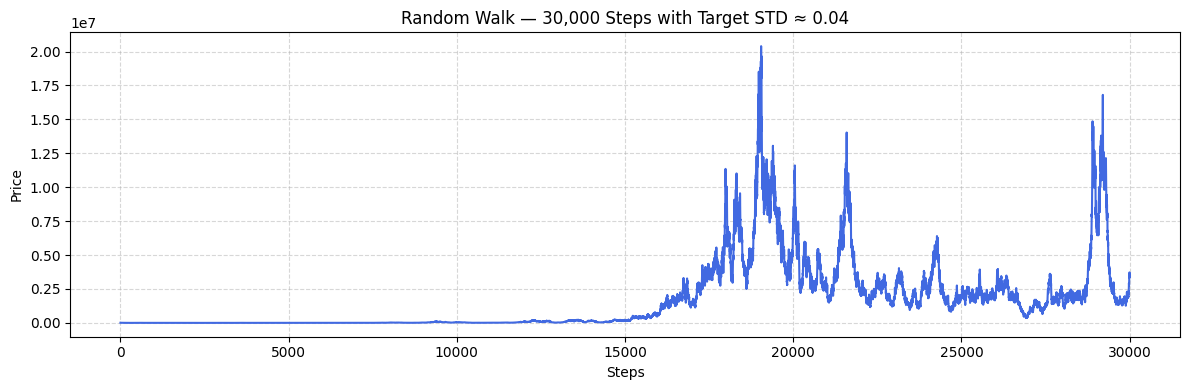

Achieved annualized vol: 0.0402 (~4.02%)


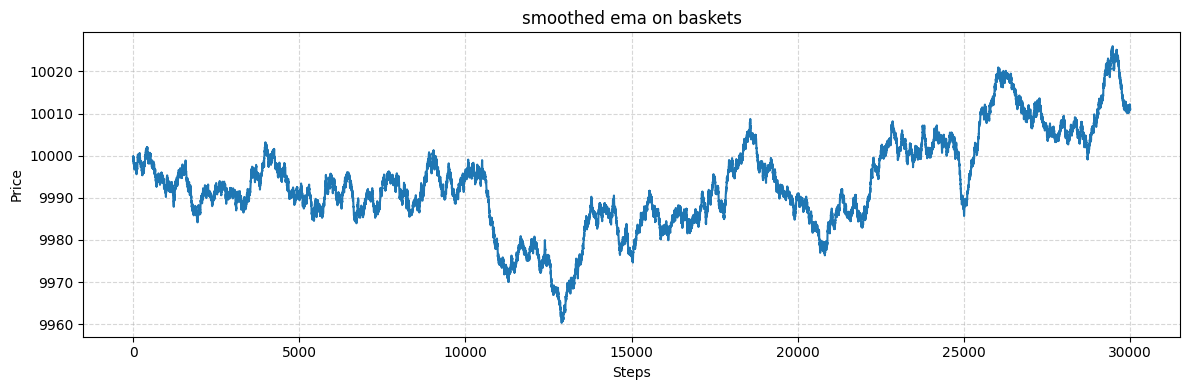

In [463]:
import numpy as np
import matplotlib.pyplot as plt

# Target std over 30,000 steps
n_steps = 30000
target_std = 0.04

# Generate normalized returns, then rescale to hit desired std
raw_returns = np.random.normal(loc=0, scale=1.0, size=n_steps)
returns = raw_returns / raw_returns.std() * target_std

# Generate price path
start_price = 10000
price_path = start_price * np.exp(np.cumsum(returns))

# Confirm result
actual_std = returns.std()
print(f"Target STD: {target_std:.4f}, Achieved STD: {actual_std:.4f}")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(price_path, color='royalblue')
plt.title("Random Walk — 30,000 Steps with Target STD ≈ 0.04")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
n_steps = 30000
days = 4
target_annual_vol = 0.04  # 4%
trading_days_per_year = 252

# Step-wise volatility to achieve target annual vol
steps_per_day = n_steps / days
steps_per_year = trading_days_per_year * steps_per_day
step_std = target_annual_vol / np.sqrt(steps_per_year)

# Generate random walk
returns = np.random.normal(loc=0, scale=step_std, size=n_steps)
price_path = 10000 * np.exp(np.cumsum(returns))

# Check actual std
actual_annualized_vol = returns.std() * np.sqrt(steps_per_year)
print(f"Achieved annualized vol: {actual_annualized_vol:.4f} (~{actual_annualized_vol*100:.2f}%)")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(price_path, label='Price Path')
plt.title("smoothed ema on baskets")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\chris\AppData\Local\Temp\ipykernel_22868\4008872775.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['ask_IV'] = v_df['ask_implied_vol'].values
C:\Users\chris\AppData\Local\Temp\ipykernel_22868\4008872775.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df['bid_IV'] = v_df['bid_implied_vol'].values
C:\Users\chris\AppData\Local\Temp\ipykernel_22868\4008872775.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

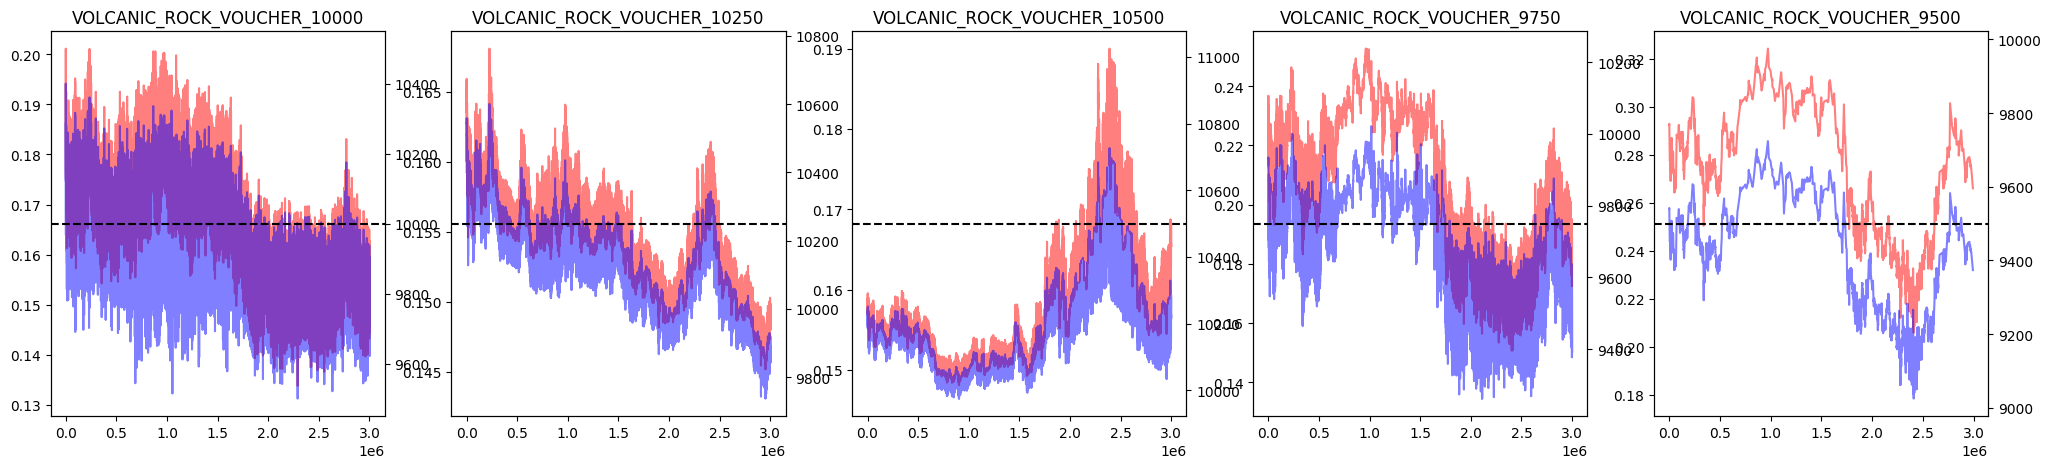

In [459]:
# i want to keep 10000 voucher and 10250 voucher and 10500 voucher
dfs = []
vouchers = ['VOLCANIC_ROCK_VOUCHER_10000', 'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500',
            'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_9500']

# vouchers = ['VOLCANIC_ROCK_VOUCHER_9750']

window = 2

plt.figure(figsize=(25, 5))
for voucher in vouchers:
    v_df = vouchers_df[vouchers_df['product'] == voucher]
    v_df['ask_IV'] = v_df['ask_implied_vol'].values
    v_df['bid_IV'] = v_df['bid_implied_vol'].values


    plt.subplot(1, 5, vouchers.index(voucher)+1)

    plt.plot(v_df['timestamp'], v_df['ask_IV'], label=voucher, alpha=0.5, c='red')
    plt.plot(v_df['timestamp'], v_df['bid_IV'], label=voucher, alpha=0.5, c='blue')
    plt.twinx()
    plt.axhline(y=v_df['strike_price'].values[0], color='black', linestyle='--')
    plt.title(voucher)


# copy_df = pd.concat(dfs)
# copy_df.reset_index(drop=True, inplace=True)

In [475]:
df = copy_df

df['m_t'] = np.log(df['strike_price'] / df['underlying_price']) / np.sqrt(df['time_to_expiry']) # moneyness = log(K/S) / sqrt(T) 
# negtive for OTM, positive for ITM

# filter for moenyness between a certain range
df = df[(df['m_t'] > -0.35) & (df['m_t'] < 0.35)]


m_t = df['m_t'].values
T = df['time_to_expiry'].values
# v_t = fix_data(df['rolled_IV'].values)
v_t_1 = df['ask_IV'].values
v_t_2 = df['bid_IV'].values

Model coefficients for ASK:
a: 0.2386154106662951
b: -0.001961415956883628
c: 0.15164395927568022
Model coefficients for BID:
a: 0.1436195242784995
b: -0.0015495217059325098
c: 0.15037740474609734


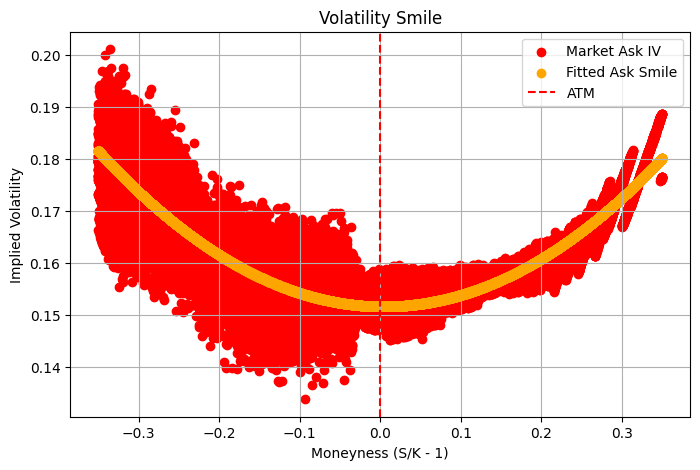

In [476]:
from sklearn.linear_model import LinearRegression
import numpy as np

X_fit = np.vstack([np.square(m_t), m_t, np.ones_like(m_t)]).T

# Ask fit
model_ask = LinearRegression().fit(X_fit, v_t_1)
Y_fit_ask = model_ask.predict(X_fit)

print("Model coefficients for ASK:")
print("a:", model_ask.coef_[0])
print("b:", model_ask.coef_[1])
print("c:", model_ask.intercept_)

# Bid fit
model_bid = LinearRegression().fit(X_fit, v_t_2)
Y_fit_bid = model_bid.predict(X_fit) 
print("Model coefficients for BID:") 
print("a:", model_bid.coef_[0]) 
print("b:", model_bid.coef_[1]) 
print("c:", model_bid.intercept_)


# Plot the fit
plt.figure(figsize=(8,5))
plt.scatter(m_t, v_t_1, label='Market Ask IV', c='red', alpha=1.0)
# plt.scatter(m_t, v_t_2, label='Market Bid IV', c='Blue', alpha=0.5)
plt.scatter(m_t, Y_fit_ask, color='orange', label='Fitted Ask Smile', alpha=1.0)
# plt.scatter(m_t, Y_fit_bid, color='purple', label='Fitted Bid Smile', alpha=0.01)


plt.axvline(0.0, color='red', linestyle='--', label='ATM')
plt.xlabel("Moneyness (S/K - 1)")
plt.ylabel("Implied Volatility")
plt.title(f"Volatility Smile")
plt.legend()
plt.grid(True)

# other params

        # volatility surface 80k on final day
        # self.bid_params = {'a': 0.17012110670572736,
        #                    'b': -0.0003175409352485575,
        #                    'c': 0.15008351274675932,}
        # self.ask_params = {'a': 0.24888418520951808,
        #                    'b': 0.00017084041647164033,
        #                    'c': 0.15166288311300313}


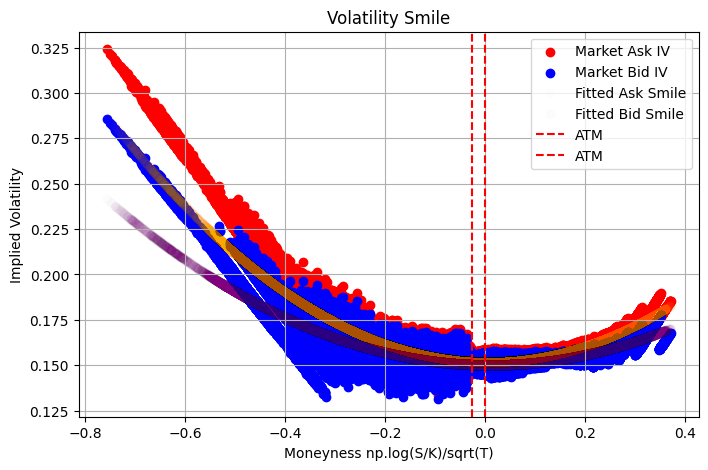

In [468]:
df = copy_df

df['m_t'] = np.log(df['strike_price'] / df['underlying_price']) / np.sqrt(df['time_to_expiry']) # moneyness = log(K/S) / sqrt(T) 
# negtive for OTM, positive for ITM

# filter for moenyness between a certain range
# df = df[(df['m_t'] > -0.3) & (df['m_t'] < 0.2)]

m_t = df['m_t'].values
T = df['time_to_expiry'].values
# v_t = fix_data(df['rolled_IV'].values)
v_t_1 = df['ask_IV'].values
v_t_2 = df['bid_IV'].values

X_fit = np.vstack([np.square(m_t), m_t, np.ones_like(m_t)]).T

# Ask fit
Y_fit_ask = model_ask.predict(X_fit)
# Bid fit
Y_fit_bid = model_bid.predict(X_fit)

# Plot the fit
plt.figure(figsize=(8,5))
plt.scatter(m_t, v_t_1, label='Market Ask IV', c='red')
plt.scatter(m_t, v_t_2, label='Market Bid IV', c='Blue')
plt.scatter(m_t, Y_fit_ask, color='orange', label='Fitted Ask Smile', alpha=0.01)
plt.scatter(m_t, Y_fit_bid, color='purple', label='Fitted Bid Smile', alpha=0.01)


plt.axvline(0.0, color='red', linestyle='--', label='ATM')
plt.axvline(-0.025, color='red', linestyle='--', label='ATM')
plt.xlabel("Moneyness np.log(S/K)/sqrt(T)")
plt.ylabel("Implied Volatility")
plt.title(f"Volatility Smile")
plt.legend()
plt.grid(True)

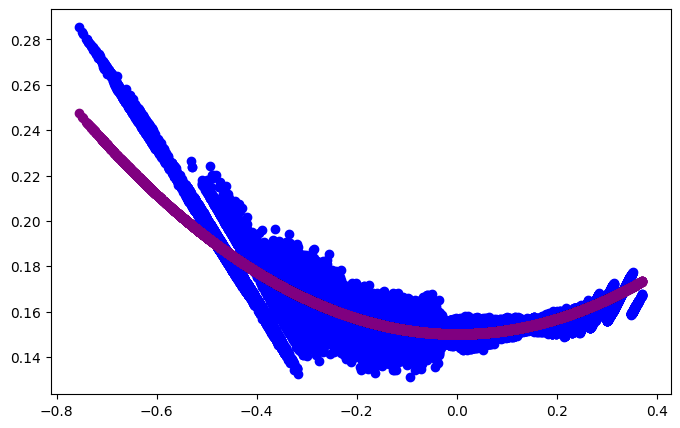

In [418]:
# Plot the fit
plt.figure(figsize=(8,5))
# plt.scatter(m_t, v_t_1, label='Market Ask IV', c='red')
plt.scatter(m_t, v_t_2, label='Market Bid IV', c='Blue')
# plt.scatter(m_t, Y_fit_ask, color='orange', label='Fitted Ask Smile')
plt.scatter(m_t, Y_fit_bid, color='purple', label='Fitted Bid Smile')


# 2d axis

Model coefficients for ASK:
a: 0.2878490683651287
b: -0.0009201058370398505
c: 0.14995106934743777
Model coefficients for BID:
a: 0.18501113144909725
b: 0.0008529599232087677
c: 0.1487917612552985


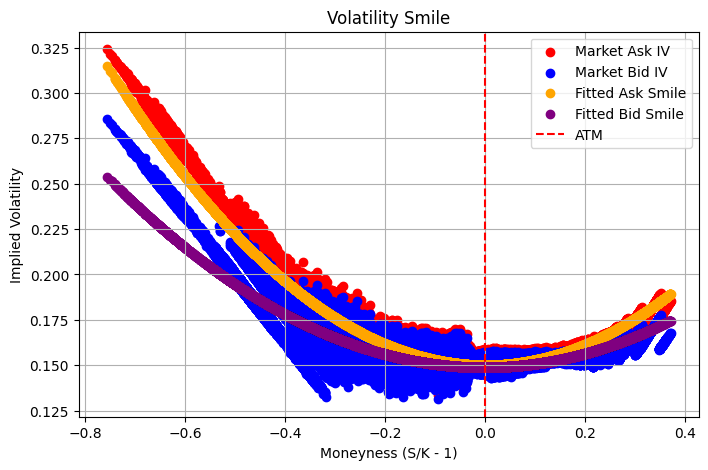

In [54]:
from sklearn.linear_model import LinearRegression
import numpy as np

X_fit = np.vstack([np.square(m_t), m_t, np.ones_like(m_t)]).T

# Ask fit
model_ask = LinearRegression().fit(X_fit, v_t_1)
Y_fit_ask = model_ask.predict(X_fit)

print("Model coefficients for ASK:")
print("a:", model_ask.coef_[0])
print("b:", model_ask.coef_[1])
print("c:", model_ask.intercept_)

# Bid fit
model_bid = LinearRegression().fit(X_fit, v_t_2)
Y_fit_bid = model_bid.predict(X_fit)
print("Model coefficients for BID:")
print("a:", model_bid.coef_[0])
print("b:", model_bid.coef_[1])
print("c:", model_bid.intercept_)


# Plot the fit
plt.figure(figsize=(8,5))
plt.scatter(m_t, v_t_1, label='Market Ask IV', c='red')
plt.scatter(m_t, v_t_2, label='Market Bid IV', c='Blue')
plt.scatter(m_t, Y_fit_ask, color='orange', label='Fitted Ask Smile')
plt.scatter(m_t, Y_fit_bid, color='purple', label='Fitted Bid Smile')


plt.axvline(0.0, color='red', linestyle='--', label='ATM')
plt.xlabel("Moneyness (S/K - 1)")
plt.ylabel("Implied Volatility")
plt.title(f"Volatility Smile")
plt.legend()
plt.grid(True)

## compare fitted vs actual 

In [ ]:
copy_df['product'].unique()

In [ ]:
vouchers = ['VOLCANIC_ROCK_VOUCHER_10000', 'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500',
            'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_9500']


copy_df = pd.concat(dfs)
copy_df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(25, 5))
i = 1
for voucher in vouchers:
    df = copy_df[copy_df['product'] == voucher]
    iv = fix_data(df['implied_vol'].values)
    plt.subplot(1, 5, i)
    i+=1
    plt.plot(df['timestamp'], iv, label='Market IV')
    plt.plot(df['timestamp'], df['fitted_iv'], label='Fitted IV')
    plt.title(voucher)
    plt.legend()
plt.show()

In [ ]:
plt.scatter(m_t, Y_fit, color='orange', label='Fitted Smile')
plt.axvline(0.0, color='red', linestyle='--', label='ATM')
plt.xlabel("Moneyness (S/K - 1)")
plt.ylabel("Implied Volatility")
plt.title(f"Volatility Smile")
plt.legend()
plt.grid(True)

copy_df['fitted_iv'] = Y_fit
copy_df['fixed_implied_vol'] = fix_data(copy_df['implied_vol'].values)
copy_df['iv_diff'] = copy_df['fixed_implied_vol'] - copy_df['fitted_iv']

In [ ]:
# plot what happens when T -> 0
df = copy_df

strike = 10000
underlying = 10400
time_to_expiry = np.linspace(0.0001, max(T), 1000)

m_t = np.log(strike / underlying) / np.sqrt(time_to_expiry) # moneyness = log(K/S) / sqrt(T)
v_t = model.predict(np.vstack([np.square(m_t), m_t, np.ones_like(m_t)]).T)
plt.figure(figsize=(8,5))
plt.plot(time_to_expiry, v_t)
plt.title(f"Implied Volatility vs Time to Expiry")
plt.xlabel("Time to Expiry")
plt.ylabel("Implied Volatility")
plt.grid(True)

# plotting and fitting like they suggested

In [ ]:
a_params = []
b_params = []
c_params = []
t = list(range(100, 3000000, 100))
for t in tqdm(range(100, 3000000, 100)):
    data = copy_df[copy_df['timestamp'] == t]

    m_t = data['m_t'].values
    v_t = data['implied_vol'].values

    X_features = np.vstack([
    m_t**2,
    m_t,
    np.ones_like(m_t)
    ]).T

    model = LinearRegression().fit(X_features, v_t)

    # Extract coefficients
    a, b, c = model.coef_[0], model.coef_[1], model.intercept_
    a_params.append(a)
    b_params.append(b)
    c_params.append(c)

In [ ]:
plt.scatter(t, c_params)
plt.axhline(y=np.mean(c_params), c='red')

In [ ]:
plt.scatter(t, b_params)
plt.axhline(y=0, c='red')

In [ ]:
plt.scatter(t, a_params)


plt.axhline(y=0, c='red')

# other

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(m_t, T, v_t)
ax.set_xlabel('m_t log(S/K)/sqrt(T)')
ax.set_ylabel('time to expiry (years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface from Market Data')
plt.tight_layout()
plt.show()

In [ ]:
# Create features: M^2, M, T, M*T, constant
X_features = np.vstack([
    m_t**2,
    m_t,
    T,
    T**2,
    m_t * T**2,
    
    m_t * T,
    np.ones_like(X)
]).T

model = LinearRegression().fit(X_features, Y)

# Extract coefficients
a, b, c, d, e = model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3], model.intercept_

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

X_fit = np.vstack([np.square(X), X, np.ones_like(X)]).T

model = LinearRegression().fit(X_fit, Y)

model.coef_[0]
model.coef_[0]
model.intercept_

Y_fit = model.predict(X_fit)

print("Model coefficients:")
print("a:", model.coef_[0])
print("b:", model.coef_[1])
print("c:", model.intercept_)

# Plot the fit
plt.figure(figsize=(8,5))
plt.scatter(X, Y, label='Market IV')
plt.scatter(X, Y_fit, color='orange', label='Fitted Smile')
plt.axvline(0.0, color='red', linestyle='--', label='ATM')
plt.xlabel("Moneyness (S/K - 1)")
plt.ylabel("Implied Volatility")
plt.title(f"Volatility Smile")
plt.legend()
plt.grid(True)

copy_df['fitted_iv'] = Y_fit
copy_df['fixed_implied_vol'] = fix_data(copy_df['implied_vol'].values)
copy_df['iv_diff'] = copy_df['fixed_implied_vol'] - copy_df['fitted_iv']

In [ ]:
# i want to keep 10000 voucher and 10250 voucher and 10500 voucher
dfs = []
dfs.append(vouchers_df[vouchers_df['product'] == 'VOLCANIC_ROCK_VOUCHER_9500'])
dfs.append(vouchers_df[vouchers_df['product'] == 'VOLCANIC_ROCK_VOUCHER_9750'])
dfs.append(vouchers_df[vouchers_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'])
dfs.append(vouchers_df[vouchers_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10250'])
dfs.append(vouchers_df[vouchers_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'])


copy_df = pd.concat(dfs)
copy_df.reset_index(drop=True, inplace=True)

copy_df['Moneyness'] = copy_df['underlying_price'] / copy_df['strike_price'] - 1 
# negtive for OTM, positive for ITM

X = copy_df['Moneyness'].values
T = copy_df['time_to_expiry'].values
Y = fix_data(copy_df['implied_vol'].values)

if Y[0] is None:
    Y[0] = Y[1]


# Create features: M^2, M, T, M*T, constant
X_features = np.vstack([
    X**2,
    X,
    T,
    X * T,
    np.ones_like(X)
]).T

model = LinearRegression().fit(X_features, Y)

# Extract coefficients
a, b, c, d, e = model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3], model.intercept_

print("Volatility Surface Equation:")
print(f"IV = {a:.4f} * M^2 + {b:.4f} * M + {c:.4f} * T + {d:.4f} * M*T + {e:.4f}")

# Create a grid for plotting
x_range = np.linspace(X.min(), X.max(), 50)
t_range = np.linspace(T.min(), T.max(), 50)
M_grid, T_grid = np.meshgrid(x_range, t_range)


# Predict implied vol on the grid
X_flat = M_grid.ravel()
T_flat = T_grid.ravel()
X_grid_features = np.vstack([
    X_flat**2,
    X_flat,
    T_flat,
    X_flat * T_flat,
    np.ones_like(X_flat)
]).T


Y_surface = model.predict(X_grid_features).reshape(M_grid.shape)


# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, T, Y, color='red', label='Market IV')
ax.plot_surface(M_grid, T_grid, Y_surface, cmap=cm.viridis, alpha=0.9)
ax.set_xlabel('Moneyness (S/K - 1)')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface from Market Data')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.linear_model import LinearRegression
import numpy as np

# Make sure your data is in the right shape
X = copy_df['Moneyness'].values
T = copy_df['time_to_expiry'].values
Y = fix_data(copy_df['implied_vol'].values)

X1 = copy_df['Moneyness'].values
T = copy_df['time_to_expiry'].values
Y = fix_data(copy_df['implied_vol'].values)

# Create features: M^2, M, T, M*T, constant
X_features = np.vstack([
    X1**2,
    X1,
    T,
    X1 * T,
    np.ones_like(X1)
]).T

model = LinearRegression().fit(X_features, Y)

# Extract coefficients
a, b, c, d, e = model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3], model.intercept_

print("Volatility Surface Equation:")
print(f"IV = {a:.4f} * M^2 + {b:.4f} * M + {c:.4f} * T + {d:.4f} * M*T + {e:.4f}")



# Create meshgrid for surface
x_range = np.linspace(X1.min(), X1.max(), 50)
t_range = np.linspace(T.min(), T.max(), 50)
X_grid, T_grid = np.meshgrid(x_range, t_range)
X1_grid_flat = X_grid.ravel()
T_grid_flat = T_grid.ravel()

X_features_grid = np.vstack([
    X1_grid_flat**2,
    X1_grid_flat,
    T_grid_flat,
    np.ones_like(X1_grid_flat)
]).T

Y_surface = model.predict(X_features_grid).reshape(X_grid.shape)



In [ ]:
a = model.coef_[0]
b = model.coef_[1]
c = model.coef_[2]
d = model.intercept_

print("Volatility Surface Equation:")
print(f"IV = {a:.4f} * (Moneyness)^2 + {b:.4f} * Moneyness + {c:.4f} * Time + {d:.4f}")

In [ ]:
voucher = 'VOLCANIC_ROCK_VOUCHER_9750'

plt.plot(copy_df[copy_df['product'] == voucher]['iv_diff'])


In [ ]:
copy_df['fitted_mid_price'] = copy_df.apply(lambda row: black_scholes_call(row['underlying_price'], row['strike_price'], row['time_to_expiry'], row['fitted_iv']), axis=1)

In [ ]:
copy_df['diff_mid_price'] = copy_df['mid_price'] - copy_df['fitted_mid_price']

voucher = 'VOLCANIC_ROCK_VOUCHER_10000'
day = 0

tmp = copy_df[copy_df['product'] == voucher]


tmp = copy_df[copy_df['product'] == voucher]['diff_mid_price'].values

bins = [-3, -2, -1, 0, 1, 2, 3]
plt.hist(tmp, bins=bins, alpha=0.5, color='blue', label='Diff Mid Price')
plt.show()

In [ ]:
voucher_df.head(2).values

In [ ]:
tte = 0.0219175342465753
underlying = 10510.0
strike = 10500.0
call_price = 102.5
IV = 0.1579951026797686
fit_iv = 0.1570176596408425

# calculate call price with fitted IV
call_1 = black_scholes_call(underlying, strike, tte, IV)
call_2 = black_scholes_call(underlying, strike, tte, fit_iv)

call_1, call_2, call_price

In [ ]:
voucher = 'VOLCANIC_ROCK_VOUCHER_10500'

a = 10.736993001294937
b = -0.034372393499278946
c = 0.1512205065875294

voucher_df = vouchers_df[vouchers_df['product'] == voucher]
voucher_df.reset_index(drop=True, inplace=True)

iv = fix_data(voucher_df['implied_vol'].values)

voucher_df['fitted_iv'] = a * np.square(voucher_df['Moneyness']) + b * voucher_df['Moneyness'] + c

difference = iv - voucher_df['fitted_iv']

plt.plot(iv, label='Market IV')
plt.plot(voucher_df['fitted_iv'], label='Fitted IV')

In [ ]:
voucher = 'VOLCANIC_ROCK_VOUCHER_9500'

voucher_df = vouchers_df[vouchers_df['product'] == voucher]

plt.plot(voucher_df['iv_diff'])
plt.xlim(0, 1000)

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import matplotlib.pyplot as plt

# Sort X for smooth plotting
sorted_idx = np.argsort(X)
X_sorted = X[sorted_idx]
Y_sorted = Y[sorted_idx]

# LOWESS smoothing (adjust frac for smoothness)
lowess_result = lowess(Y_sorted, X_sorted, frac=0.1, return_sorted=True)
x_lowess, y_lowess = lowess_result[:, 0], lowess_result[:, 1]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, label='Market IV')
plt.plot(x_lowess, y_lowess, color='orange', label='LOWESS Smile')
plt.axvline(0.0, color='red', linestyle='--', label='ATM')
plt.xlabel("Moneyness (S/K - 1)")
plt.ylabel("Implied Volatility")
plt.title("Volatility Smile (LOWESS Fit)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
vouchers = ['VOLCANIC_ROCK_VOUCHER_10500',
            'VOLCANIC_ROCK_VOUCHER_10250',
            'VOLCANIC_ROCK_VOUCHER_10000',
            'VOLCANIC_ROCK_VOUCHER_9750',
            'VOLCANIC_ROCK_VOUCHER_9500']

underlying_prices = vouchers_df[vouchers_df['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'][['underlying_price', 'timestamp']]
plt.plot(underlying_prices['underlying_price'])
plt.axhline(10500, color='red', linestyle='--')
plt.axhline(10250, color='red', linestyle='--')
plt.axhline(10000, color='red', linestyle='--')
plt.axhline(9750, color='red', linestyle='--')
plt.axhline(9500, color='red', linestyle='--')

In [ ]:
underlying_prices['underlying_price']

returns = np.log(underlying_prices['underlying_price'] / underlying_prices['underlying_price'].shift(1))
rv_std = returns.std()

hard_coded_rv = rv_std * np.sqrt(365 * 10000)
hard_coded_rv 

In [ ]:
from math import log, sqrt, exp
from statistics import NormalDist

class BlackScholes:
    @staticmethod
    def black_scholes_call(spot, strike, time_to_expiry, volatility):
        d1 = (
            log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * sqrt(time_to_expiry))
        d2 = d1 - volatility * sqrt(time_to_expiry)
        call_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
        return call_price

    @staticmethod
    def black_scholes_put(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot / strike) + (0.5 * volatility * volatility) * time_to_expiry) / (
            volatility * sqrt(time_to_expiry)
        )
        d2 = d1 - volatility * sqrt(time_to_expiry)
        put_price = strike * NormalDist().cdf(-d2) - spot * NormalDist().cdf(-d1)
        return put_price

    @staticmethod
    def delta(spot, strike, time_to_expiry, volatility):
        d1 = (
            log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * sqrt(time_to_expiry))
        return NormalDist().cdf(d1)

    @staticmethod
    def gamma(spot, strike, time_to_expiry, volatility):
        d1 = (
            log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * sqrt(time_to_expiry))
        return NormalDist().pdf(d1) / (spot * volatility * sqrt(time_to_expiry))

    @staticmethod
    def vega(spot, strike, time_to_expiry, volatility):
        d1 = (
            log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * sqrt(time_to_expiry))
        return NormalDist().pdf(d1) * (spot * sqrt(time_to_expiry)) / 100

    @staticmethod
    def implied_volatility(
        call_price, spot, strike, time_to_expiry, max_iterations=200, tolerance=1e-10
    ):
        low_vol = 0.001
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        for _ in range(max_iterations):
            estimated_price = BlackScholes.black_scholes_call(
                spot, strike, time_to_expiry, volatility
            )
            diff = estimated_price - call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility
    
model = BlackScholes()

In [ ]:
voucher = vouchers[4]
plt.figure(figsize=(25, 5))
i = 1
for voucher in vouchers:
    voucher_df = vouchers_df[vouchers_df['product'] == voucher]
    strike_price = int(voucher.split('_')[-1])

    # voucher_df['value'] = voucher_df.apply(lambda row: black_scholes_call(row['underlying_price'], row['strike_price'], row['time_to_expiry'], row['RV']), axis=1)

    # IV = pd.Series(fix_data(voucher_df['implied_vol'].values))
    # diff = RV - IV

    # diff = voucher_df['value'] - voucher_df['mid_price']

    IV = pd.Series(fix_data(voucher_df['implied_vol'].values))

    difference = IV - hard_coded_rv

    plt.subplot(1, 5, i)
    i += 1
    plt.plot(difference)
    # plt.plot(RV, label='real_vol')
    plt.legend()
    plt.title(f'STRIKE: {strike_price}')
    plt.xlabel('Time')
    plt.ylabel('Difference')

    plt.plot()

